In [1]:

# load libraries
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(tidyverse)
quiet_library(Seurat)
quiet_library(ggplot2)
quiet_library(Matrix)
quiet_library(dplyr)
quiet_library(viridis)
quiet_library(harmony)
quiet_library(future)
quiet_library(future.apply)
quiet_library(SingleCellExperiment)
quiet_library(SeuratDisk)
quiet_library(ggpubr)
quiet_library(knitr)
quiet_library(plotly)
quiet_library(lme4)
quiet_library(ggpubr)
quiet_library(ggrepel)
quiet_library(ggthemes)
options(warn = -1)

In [2]:
# Check number of cores
future::availableCores()
# Set up parallel processing to run when using 'future' functions 
future::plan(strategy = "multicore", workers = future::availableCores()-5)  
options(future.globals.maxSize = 1000 * 1024^3)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")

system 
    64

In [3]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")

cluster_colors_ext <- colorRampPalette(cluster_colors)(75)
options(repr.plot.width = 5, repr.plot.height = 5)

In [4]:
df=read.csv("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_notebooks/files/input_files/scRNA_Table_input_files/ALTRA_Prediction_score_AIFI.csv")
df%>%head(3)

,X,barcodes,AIFI_L1,AIFI_L1_score,AIFI_L2,AIFI_L2_score,AIFI_L3,AIFI_L3_score
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,0,6a185d4cc0a311ebb325a228a802157d,T cell,0.9999537,Naive CD4 T cell,0.6890866,ISG+ naive CD4 T cell,1
2,1,ca5551b4dc5f11eca5893ed7e0e9bbf0,T cell,0.9997939,Naive CD4 T cell,0.9973370,ISG+ naive CD4 T cell,1
3,2,e467d71076fe11eb934cc6c1afd85b40,T cell,0.9999406,Naive CD4 T cell,0.9983612,ISG+ naive CD4 T cell,1


In [5]:
df <- df %>%
  mutate(AIFI_L1_5 = as.character(AIFI_L2)) %>%
  mutate(AIFI_L1_5 = case_when(
    grepl('CD4', AIFI_L1_5) ~ 'CD4_T',
    grepl('CD8', AIFI_L1_5) ~ 'CD8_T',
    AIFI_L1_5 %in% c('DN T cell', 'MAIT', 'Proliferating T cell') ~ 'Other_T',
    grepl('monocyte', AIFI_L1_5) ~ 'mono',
    grepl('DC', AIFI_L1_5) ~ 'DC',
    grepl('NK', AIFI_L1_5) ~ 'NK',
    AIFI_L1_5 %in% c('Naive B cell', 'Transitional B cell') ~ 'Naive B cell',
    AIFI_L1_5 %in% c('Effector B cell', 'Memory B cell') ~ 'Memory B cell',
    AIFI_L1_5 %in% c('Platelet', 'Erythrocyte', 'Progenitor cell') ~ 'Other',
    TRUE ~ AIFI_L1_5
  ))
df%>%head()

,X,barcodes,AIFI_L1,AIFI_L1_score,AIFI_L2,AIFI_L2_score,AIFI_L3,AIFI_L3_score,AIFI_L1_5
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,0,6a185d4cc0a311ebb325a228a802157d,T cell,0.9999537,Naive CD4 T cell,0.6890866,ISG+ naive CD4 T cell,1,CD4_T
2,1,ca5551b4dc5f11eca5893ed7e0e9bbf0,T cell,0.9997939,Naive CD4 T cell,0.9973370,ISG+ naive CD4 T cell,1,CD4_T
3,2,e467d71076fe11eb934cc6c1afd85b40,T cell,0.9999406,Naive CD4 T cell,0.9983612,ISG+ naive CD4 T cell,1,CD4_T
4,3,b183f0c6dc5c11eca3e6166421532e92,T cell,0.9998584,Naive CD4 T cell,0.9964270,ISG+ naive CD4 T cell,1,CD4_T
5,4,ac2212a8c0a511eb92cb5ea76614d713,T cell,0.9999923,Naive CD4 T cell,0.9965519,ISG+ naive CD4 T cell,1,CD4_T
6,5,802ac68aac8411eabc72fe31e0a2389d,T cell,0.9999456,Naive CD4 T cell,0.9887009,ISG+ naive CD4 T cell,1,CD4_T


## Figure S10 A

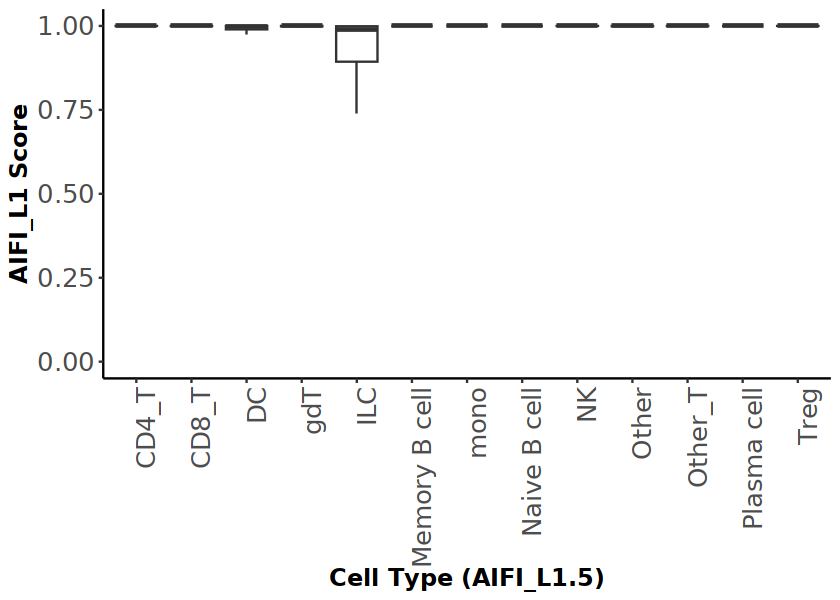

In [6]:
options(repr.plot.width = 7, repr.plot.height = 5)
p1_5=ggplot(df, aes(x = AIFI_L1_5, y = AIFI_L1_score)) +
  geom_boxplot(outlier.shape = NA) +  # Removes outliers from the box plot
  #geom_boxplot() +  # Creates the box plot
  theme_classic() +  # A cleaner theme for the plot
  labs(x = "Cell Type (AIFI_L1.5)", y = "AIFI_L1 Score") +  # Labels for x and y axes
  theme(axis.text = element_text(size = 15), 
        axis.title = element_text(size = 14, face = "bold"),
        axis.text.x = element_text(angle = 90, hjust = 1))
p1_5

In [7]:
ggsave("/home/jupyter/ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/Fig_S10_A.pdf",plot = p1_5, width =7, height = 5, units = "in")

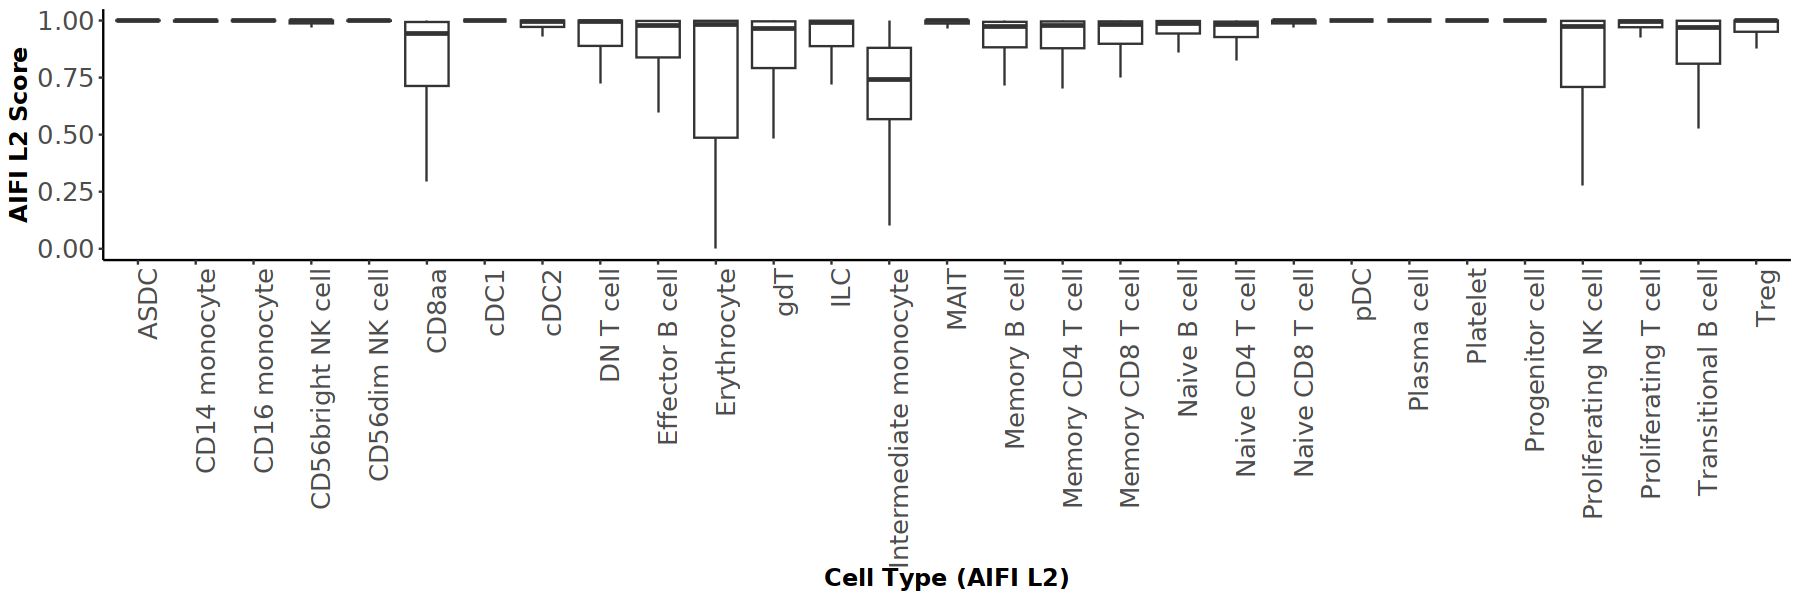

In [8]:
options(repr.plot.width = 15, repr.plot.height = 5)
p2=ggplot(df, aes(x = AIFI_L2, y = AIFI_L2_score))+
  geom_boxplot(outlier.shape = NA) +  # Removes outliers from the box plot
  #geom_boxplot() +  # Creates the box plot
  theme_classic() +  # A cleaner theme for the plot
  labs(x = "Cell Type (AIFI L2)", y = "AIFI L2 Score") +  # Labels for x and y axes
  theme(axis.text = element_text(size = 15), 
        axis.title = element_text(size = 14, face = "bold"),
        axis.text.x = element_text(angle = 90, hjust = 1))
p2

In [9]:
ggsave("/home/jupyter//ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/Fig_S10_B.pdf",plot = p2, width =15, height = 5, units = "in")

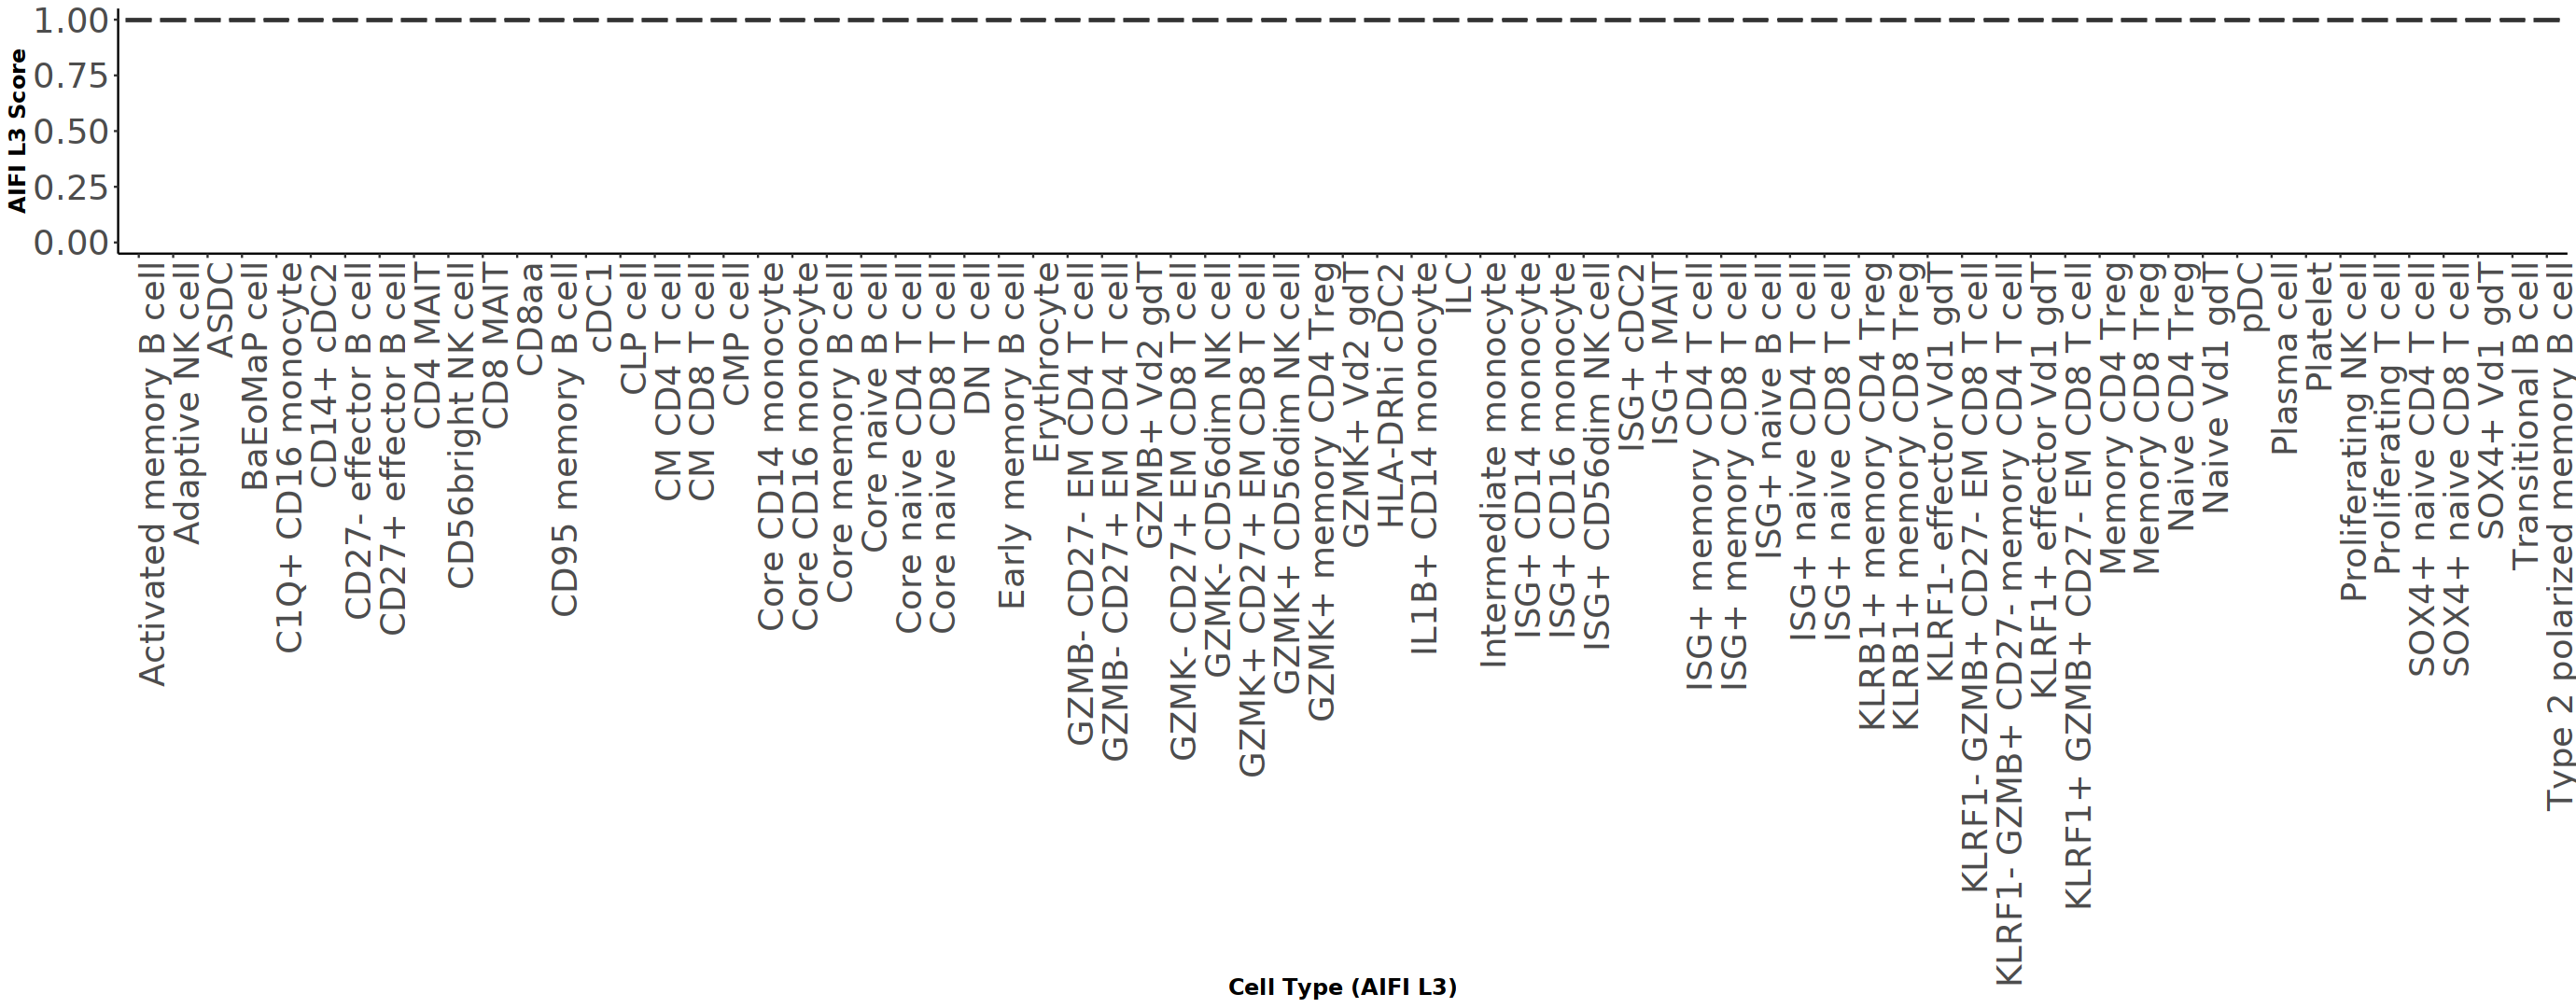

In [10]:
options(repr.plot.width = 23, repr.plot.height = 9)
p3 = ggplot(df, aes(x = AIFI_L3, y = AIFI_L3_score)) +
  geom_boxplot(outlier.shape = NA) +  # Removes outliers from the box plot
  theme_classic() +  # A cleaner theme for the plot
  labs(x = "Cell Type (AIFI L3)", y = "AIFI L3 Score") +  # Labels for x and y axes
  theme(axis.text = element_text(size = 22), 
        axis.title = element_text(size = 14, face = "bold"),
        axis.text.x = element_text(angle = 90, hjust = 1)) +
  ylim(0, 1)  # Sets y-axis limits from 0 to 1

p3

In [11]:
ggsave("/home/jupyter//ALTRA_ANALYSIS/Deep_clean/Figure_files/Certpro_figures/Plots_for_manuscript/Fig_S10_c.pdf",plot = p3, width =15, height = 5, units = "in")

In [12]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/jupyter/libs/r_scrna/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggthemes_5.1.0              ggrepel_0.9.5              
 [3] lme4_1.1-34                 plotly_4.10.4              
 [5] knitr_1.47                  ggpubr_0.6.0               
 [7] SeuratDisk_0.0.0.9021       SingleCellExperiment_1.22.0
 [9] SummarizedExperiment_1.30.2 Biobas